In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from datasets import load_dataset
from torch.utils.data import DataLoader

dataset_dict = load_dataset("fashion_mnist")
dataset_dict

Reusing dataset fashion_mnist (/home/mingyuliu/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

<class 'PIL.PngImagePlugin.PngImageFile'>


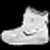

In [3]:
temp = dataset_dict['train'][0]['image']
print(type(temp))
temp.resize((50, 50)).show()

In [4]:
from torchvision.transforms import Compose, Normalize, ToTensor

normalize = Normalize(mean=(0.286,), std=(0.353,))
transformations = Compose([ToTensor(), normalize])

In [5]:
def transform_fn(examples):
    examples["pixel_values"] = [transformations(img) for img in examples["image"]]
    del examples["image"]
    return examples

In [6]:
dataset_transformed_dict = dataset_dict.with_transform(transform_fn)
dataset_transformed_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [7]:
batch_size = 2
data_loader = DataLoader(dataset_transformed_dict['train'], batch_size=batch_size, shuffle=True)
examples = next(iter(data_loader))
examples

{'label': tensor([4, 6]),
 'pixel_values': tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           ...,
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]]],
 
 
         [[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           ...,
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]]]])}

In [8]:
from torchmetrics import Accuracy

class ClassificationModule(pl.LightningModule):

    def __init__(self, n_classes: int, learning_rate: float):
        super().__init__()
        
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU()
                                )
        self.fc1 = nn.Linear(256, n_classes)
        
        self.train_accuracy = Accuracy()
        self.val_accuracy = Accuracy()

    def forward(self, pixel_values_batch):        
        output = self.convnet(pixel_values_batch)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return self.fc1(output)
    
    def training_step(self, batch):
        loss = self.compute_metric(batch, split='train')
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_accuracy', self.train_accuracy, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.compute_metric(batch, split='val')
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('val_accuracy', self.val_accuracy, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def compute_metric(self, batch, split):
        pixel_values_batch = batch['pixel_values']
        labels_batch = batch['label']
        output_batch = self(pixel_values_batch)
        loss = F.cross_entropy(output_batch, labels_batch)
        pred_batch = output_batch.argmax(dim=1)
        if split == 'train':
            self.train_accuracy.update(pred_batch, labels_batch)
        elif split == 'val':
            self.val_accuracy.update(pred_batch, labels_batch)
        
        return loss

    def get_embedding(self, pixel_values_batch):
        with torch.no_grad():
            output = self.convnet(pixel_values_batch)
            output = output.view(output.size()[0], -1)
            output = self.fc(output)

        return output

In [9]:
classification_module = ClassificationModule(
    n_classes=10,
    learning_rate=0.01
)
outputs = classification_module(examples['pixel_values'])
outputs

tensor([[-0.0654, -0.0521, -0.0539, -0.0142, -0.0256, -0.0109, -0.1167,  0.0472,
         -0.0188, -0.0584],
        [-0.0557, -0.0254, -0.0499, -0.0318, -0.0036,  0.0111, -0.0803,  0.0413,
         -0.0222, -0.0335]], grad_fn=<AddmmBackward0>)

In [10]:
batch_size = 256
train_data_loader = DataLoader(dataset_transformed_dict['train'], batch_size=batch_size, shuffle=True, num_workers=4)
val_data_loader = DataLoader(dataset_transformed_dict['test'], batch_size=batch_size, shuffle=False, num_workers=4)

In [11]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss')]
csv_logger = CSVLogger(save_dir=os.getcwd())
trainer = pl.Trainer(logger=csv_logger, callbacks=callbacks, max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(classification_module, train_dataloaders=train_data_loader, val_dataloaders=val_data_loader)


  | Name           | Type       | Params
----------------------------------------------
0 | convnet        | Sequential | 52.1 K
1 | fc             | Sequential | 328 K 
2 | fc1            | Linear     | 2.6 K 
3 | train_accuracy | Accuracy   | 0     
4 | val_accuracy   | Accuracy   | 0     
----------------------------------------------
382 K     Trainable params
0         Non-trainable params
382 K     Total params
1.531     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
classification_module.get_embedding(examples['pixel_values']).shape

torch.Size([2, 256])

## Triplet Loss

In [14]:
batch_size = 5
data_loader = DataLoader(dataset_transformed_dict['train'], batch_size=batch_size, shuffle=False)
examples = next(iter(data_loader))
examples

{'label': tensor([9, 0, 0, 3, 0]),
 'pixel_values': tensor([[[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           ...,
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]]],
 
 
         [[[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           ...,
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
           [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]]],
 
 
         [[[-0.8102, -0.8102,

In [15]:
# def hardest_negative(loss_values):
#     hard_negative = np.argmax(loss_values)
#     return hard_negative if loss_values[hard_negative] > 0 else None


# def random_hard_negative(loss_values):
#     hard_negatives = np.where(loss_values > 0)[0]
#     return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None


# def semihard_negative(loss_values, margin):
#     semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
#     return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

In [16]:
import random


def get_triplets(output_batch, labels_batch, margin: float = 1.0):
    triplets = []
    with torch.no_grad():
        distance_matrix = torch.cdist(output_batch, output_batch)

        for label in set(labels_batch.cpu().numpy()):
            label_mask = labels_batch == label
            positive_indices = label_mask.nonzero(as_tuple=True)[0]
            if len(positive_indices) < 2:
                continue

            negative_indices = torch.logical_not(label_mask).nonzero(as_tuple=True)[0]
            # sample positive pairs, combination of pairs that have the same label
            # in a particular input batch
            # [[1, 2],
            #  [1, 4],
            #  [2, 4]]
            anchor_positives = torch.combinations(positive_indices)
            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            # for every one the the anchor record, lookup the distance for all the negative indices
            an_distances = distance_matrix[
                anchor_positives[:, 0].unsqueeze(dim=1),
                negative_indices.unsqueeze(dim=0)
            ]
            # loss values looks something like the following
            # tensor([[1.4446, 1.2542],
            #         [0.8806, 0.6901],
            #         [0.9336, 1.5853]])
            # where the number of rows is the number of anchored samples,
            # and number of columns is the number of anchored negative samples
            # each cell represents the triplet loss between each pair
            loss_values = ap_distances.unsqueeze(dim=1) - an_distances + margin
            for i, loss_value in enumerate(loss_values):
                hard_negatives = (loss_value > 0).nonzero(as_tuple=True)[0]
                if len(hard_negatives) > 0:
                    anchor_positive = anchor_positives[i]
                    hard_negative = hard_negatives[random.randrange(len(hard_negatives))]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

    return torch.LongTensor(triplets)

In [40]:
class TripletModule(pl.LightningModule):

    def __init__(self, learning_rate: float, margin: float = 1.0):
        super().__init__()

        self.learning_rate = learning_rate
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU()
                                )
        
        self.triplet_loss = nn.TripletMarginLoss(margin)
        self.train_accuracy = Accuracy()
        self.val_accuracy = Accuracy()

    def forward(self, pixel_values_batch):        
        output = self.convnet(pixel_values_batch)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def training_step(self, batch):
        loss = self.compute_metric(batch, split='train')
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_accuracy', self.train_accuracy, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.compute_metric(batch, split='val')
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('val_accuracy', self.val_accuracy, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def compute_metric(self, batch, split):
        pixel_values_batch = batch['pixel_values']
        labels_batch = batch['label']
        output_batch = self(pixel_values_batch)
        triplets = get_triplets(output_batch, labels_batch)
        loss = self.triplet_loss(
            output_batch[triplets[:, 0]],
            output_batch[triplets[:, 1]],
            output_batch[triplets[:, 2]]
        )

        pred_batch = output_batch.argmax(dim=1)
        if split == 'train':
            self.train_accuracy.update(pred_batch, labels_batch)
        elif split == 'val':
            self.val_accuracy.update(pred_batch, labels_batch)
        
        return loss
    
    def get_embedding(self, pixel_values_batch):
        with torch.no_grad():
            return self(pixel_values_batch)

In [42]:
triplet_module = TripletModule(
    learning_rate=0.01
)
output_batch = triplet_module(examples['pixel_values'])
output_batch

tensor([[ 0.0975,  0.1213, -0.0118,  ...,  0.1768, -0.0196,  0.0240],
        [ 0.0373,  0.1125, -0.0132,  ...,  0.1379, -0.0075, -0.0066],
        [-0.0004,  0.0445, -0.0068,  ...,  0.0468,  0.0284, -0.0086],
        [-0.0042,  0.0692, -0.0049,  ...,  0.0335,  0.0506, -0.0063],
        [ 0.0488,  0.0666, -0.0185,  ...,  0.1263,  0.0495, -0.0051]],
       grad_fn=<PreluBackward0>)

In [43]:
labels_batch = examples['label']
loss_values = get_triplets(output_batch, labels_batch)
loss_values

tensor([[1, 2, 1],
        [1, 4, 0],
        [2, 4, 1]])

In [44]:
batch_size = 256
train_data_loader = DataLoader(dataset_transformed_dict['train'],
                               batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_data_loader = DataLoader(dataset_transformed_dict['test'],
                             batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

In [45]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss')]
csv_logger = CSVLogger(save_dir=os.getcwd())
trainer = pl.Trainer(logger=csv_logger, callbacks=callbacks, max_epochs=8)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [46]:
trainer.fit(triplet_module, train_dataloaders=train_data_loader, val_dataloaders=val_data_loader)


  | Name           | Type              | Params
-----------------------------------------------------
0 | convnet        | Sequential        | 52.1 K
1 | fc             | Sequential        | 328 K 
2 | triplet_loss   | TripletMarginLoss | 0     
3 | train_accuracy | Accuracy          | 0     
4 | val_accuracy   | Accuracy          | 0     
-----------------------------------------------------
380 K     Trainable params
0         Non-trainable params
380 K     Total params
1.521     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [60]:
%load_ext tensorboard

## Validation

In [47]:
triplet_embedding = triplet_module.get_embedding(examples['pixel_values']).cpu().numpy()
triplet_embedding

array([[-0.02374348, -0.0330015 , -0.01327282, ..., -0.02302296,
        -0.02591417, -0.07701071],
       [-0.02785763, -0.03012087, -0.02293666, ..., -0.01449264,
        -0.02499893, -0.01534667],
       [-0.01808958, -0.02305187, -0.02700065, ..., -0.02027208,
        -0.01377209, -0.0205295 ],
       [-0.02022461, -0.02194866, -0.02869061, ..., -0.01896765,
        -0.01464459, -0.02315643],
       [-0.02493794, -0.02058965, -0.03398969, ..., -0.01907356,
        -0.01696688, -0.03401559]], dtype=float32)

In [64]:
triplet_module(examples['pixel_values']).shape

tensor([63, 17, 17, 17, 17])

In [62]:
classification_embedding.shape

(5, 256)

In [48]:
classification_embedding = classification_module.get_embedding(examples['pixel_values']).cpu().numpy()
classification_embedding

array([[-0.18590035,  0.69543445, -0.12769291, ..., -0.38221785,
        -0.07774707, -0.14000985],
       [-1.1597943 , -0.84390825, -0.85677   , ..., -0.39835724,
        -0.8526008 , -0.5245402 ],
       [-0.56920743, -0.28905666, -0.3798801 , ..., -0.24877268,
        -0.2996576 , -0.20176551],
       [-0.8669773 , -0.18268648, -0.19739115, ..., -0.16345558,
        -0.25248703, -0.26821074],
       [-0.5066965 , -0.236029  , -0.5352296 , ..., -0.18034178,
        -0.18281743, -0.14495897]], dtype=float32)

In [49]:
import faiss


def create_index(module, data_loader):
    # https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances#how-can-i-index-vectors-for-cosine-similarity
    faiss_index = faiss.IndexHNSWFlat(256, 32, faiss.METRIC_INNER_PRODUCT)

    for examples in data_loader:
        embedding = module.get_embedding(examples['pixel_values']).cpu().numpy()
        faiss.normalize_L2(embedding)
        faiss_index.add(embedding)
    
    return faiss_index


In [50]:
faiss_index = create_index(classification_module, val_data_loader)
print(faiss_index.ntotal)

9984


In [52]:
input_example = dataset_transformed_dict['test'][0]['pixel_values'].unsqueeze(dim=0)
input_embedding = classification_module.get_embedding(input_example).cpu().numpy()
faiss.normalize_L2(input_embedding)

In [53]:
distances, indices = faiss_index.search(input_embedding, 5)
indices

array([[   0, 5151, 9363, 4320, 7402]])

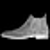

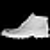

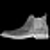

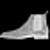

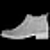

In [54]:
for index in indices[0]:
    index = int(index)
    dataset_dict['test'][index]['image'].resize((50, 50)).show()

In [55]:
faiss_index = create_index(triplet_module, val_data_loader)
print(faiss_index.ntotal)

9984


In [56]:
input_example = dataset_transformed_dict['test'][0]['pixel_values'].unsqueeze(dim=0)
input_embedding = triplet_module.get_embedding(input_example).cpu().numpy()
faiss.normalize_L2(input_embedding)

In [57]:
distances, indices = faiss_index.search(input_embedding, 5)
indices

array([[   0, 5788, 8871, 6052, 9034]])

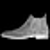

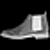

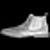

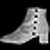

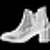

In [58]:
for index in indices[0]:
    index = int(index)
    dataset_dict['test'][index]['image'].resize((50, 50)).show()

# Reference

- https://pytorch-lightning.readthedocs.io/en/latest/notebooks/lightning_examples/mnist-hello-world.html